# 16 · Tokenizer‐level control for language–brain RSA

Estimate how much parcel‑wise language–brain RSA can be explained by token occurrence statistics alone (i.e., “bag‑of‑tokens/words”), rather than by deeper model representations.

Steps:

Load precomputed tokenizer‑based RDM → parcel RSA (counts/jaccard/one‑hot).

Compare six LLM tokenizers (BLOOMZ, Gemma‑2, LLaMA‑2/3, Open‑LLaMA) and simple word/stem tokenizers.

Relate tokenizer–brain RSA to:

1. Inter‑subject RSA (vision‑like geometry),

2. First‑layer language RSA,

3. Max language RSA across layers.

4. Visualise cortical maps and cross‑measure correlations.



**Imports & setup.**  
Load common scientific/plotting libraries and project helpers.  
- `setup_matplotlib_fonts()` standardises fonts (Arial).  
- Define all file paths and output folders.  
- Predefine a few ROI sets for quick reference (visual/ventral/dorsal clusters).


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Project helper functions
from convergence.figures import plot_cbar_set, setup_matplotlib_fonts
from convergence.figures_utils import proccess_alignment
from convergence.plotting import plot_faverage_parcelation
from convergence.operations import interpolate_alignment_series, unpack_scores

# Change font to arial
setup_matplotlib_fonts()

In [2]:
derivatives_folder = Path("../derivatives")

hcp_filename = derivatives_folder / "metadata" / "hcp.csv"
models_filename = derivatives_folder / "metadata" /"models-info.csv"

filename_tokens = derivatives_folder / "nsd" / "supplementary_tokenizers_rsa_joined.parquet"
pvalues_filename = derivatives_folder / "nsd" / "rsa_pvalues_subject_language_vision.parquet"

filename_intersubject = derivatives_folder / "nsd" / "rsa_subject_subject_alignment_shift_1_joined.parquet"
filename_model_alignment_joined = derivatives_folder / "nsd" / "rsa_subject_model_alignment_joined.parquet"

figures_folder = Path("../figures")
output_folder = figures_folder / "16_tokenizer_analysis_supplementary"
output_folder.mkdir(exist_ok=True, parents=True)


visual_cortex = ["V1", "V2", "V3", "V4"]
ventral_cluster = ["VMV1", "VMV2", "VMV3", "PHA1", "PHA2", "PHA3"]
dorsal_cluster = ["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"]


Peek at the tokenizer RSA parquet to confirm structure (roi × subject × tokenizer × metrics). No processing here—just visual inspection.


In [3]:
pd.read_parquet(filename_tokens)

,subject,session,roi,tokenizer,metric,jaccard_score,correlation_score,correlation_freq_score,n_stimuli
0,1,shared,1,words,rsa,-0.008111,-0.008494,-0.026057,1000
1,1,shared,1,stems,rsa,-0.004249,-0.004682,-0.023531,1000
2,1,shared,1,words_clean,rsa,-0.005575,-0.006171,-0.005775,1000
3,1,shared,1,stems_clean,rsa,0.002802,0.002792,0.003415,1000
4,1,shared,1,bigscience/bloomz-560m,rsa,0.003025,0.003697,-0.009469,1000
...,...,...,...,...,...,...,...,...,...
11335,7,shared,180,bigscience/bloomz-560m,rsa,0.013678,0.014274,0.019696,1000
11336,7,shared,180,openlm-research/open_llama_3b,rsa,0.015021,0.015438,0.019051,1000
11337,7,shared,180,meta-llama/Meta-Llama-3-8B,rsa,0.014797,0.015239,0.020136,1000
11338,7,shared,180,meta-llama/Llama-2-7b,rsa,0.013391,0.013943,0.018756,1000


## Prepare data

**Prepare core brain measures.**  
`proccess_alignment()` aggregates:  
- Inter‑subject RSA (`intersubject_rsa`)  
- Language model RSA maxima (`language_rsa`)  
following the manuscript’s standard pipeline (subject averaging, hemisphere join, etc.).  
We’ll merge these with tokenizer scores later.


In [4]:
df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    hcp_filename=hcp_filename,
    models_alignment_filename=filename_model_alignment_joined,
    subject_alignment_filename=filename_intersubject,
    pvalues_filename=pvalues_filename,
    group_subject=True)

df_comparison_subjects

,roi,intersubject_rsa,language_rsa,language_depth,vision_rsa,vision_depth,intersubject_p_value,intersubject_null_mean,intersubject_null_std,intersubject_apa_star,...,mne_name,roi_order,vision_p_value,vision_null_mean,vision_null_std,vision_apa_star,language_p_value,language_null_mean,language_null_std,language_apa_star
0,1,0.194511,-0.001745,0.426195,0.165118,0.192689,0.000161,9.465456e-06,0.003569,***,...,L_V1_ROI-lh,0,0.000103,0.000916,0.002052,***,0.351028,0.000711,0.002266,n.s.
1,2,0.210775,0.164321,0.553400,0.129602,0.783711,0.000161,6.518135e-06,0.002293,***,...,L_MST_ROI-lh,24,0.000103,0.000470,0.001593,***,0.000225,0.000365,0.001762,***
2,3,0.012278,0.016045,0.449522,0.051810,0.498165,0.000161,-3.537752e-06,0.001275,***,...,L_V6_ROI-lh,7,0.000103,0.000408,0.001456,***,0.000225,0.000316,0.001603,***
3,4,0.177940,-0.011911,0.396577,0.166150,0.198885,0.000161,9.280093e-07,0.003676,***,...,L_V2_ROI-lh,1,0.000103,0.000968,0.002073,***,0.000225,0.000737,0.002296,***
4,5,0.125448,-0.018913,0.382483,0.139557,0.225051,0.000161,2.677682e-05,0.003430,***,...,L_V3_ROI-lh,2,0.000103,0.001055,0.002085,***,0.000225,0.000802,0.002311,***
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,0.004292,0.016640,0.477573,0.024621,0.575501,0.000161,-9.744754e-06,0.000687,***,...,L_STSva_ROI-lh,64,0.000103,0.000251,0.001060,***,0.000225,0.000219,0.001180,***
176,177,0.001881,0.002840,0.403661,0.011111,0.491419,0.021059,-1.083623e-05,0.000804,*,...,L_TE1m_ROI-lh,89,0.000103,0.000239,0.001132,***,0.053525,0.000210,0.001244,n.s.
177,178,0.000320,0.001015,0.400036,0.004509,0.459489,0.003941,3.755545e-07,0.000105,**,...,L_PI_ROI-lh,75,0.000103,0.000144,0.000591,***,0.227360,0.000129,0.000641,n.s.
178,179,0.001305,0.000871,0.425983,0.011757,0.508894,0.020357,-5.608162e-06,0.000546,*,...,L_a32pr_ROI-lh,141,0.000103,0.000221,0.001015,***,0.590587,0.000182,0.001098,n.s.


**Aggregate tokenizer RSA per ROI.**  
We average across subjects for each `(roi, tokenizer)` pair. Three similarity flavours are provided:  
- `jaccard_score` (set overlap),  
- `correlation_score` (one‑hot),  
- `correlation_freq_score` (token counts; closest to our main RSA).  
We’ll focus on the frequency version for plots but keep others for completeness.


In [5]:
# Tokenizers (models and classic)
df = pd.read_parquet(filename_tokens)
df = df.groupby(["roi", "tokenizer"], observed=True).aggregate({"jaccard_score": "mean", "correlation_score": "mean", "correlation_freq_score": "mean"}).reset_index()
df_hcp = pd.read_csv(hcp_filename)
df_hcp = df_hcp[["roi", "name", "mne_name", "area", "area_id", "area_color"]]
df_tokens = df.merge(df_hcp, on="roi", how="left")
df_tokens

,roi,tokenizer,jaccard_score,correlation_score,correlation_freq_score,name,mne_name,area,area_id,area_color
0,1,bigscience/bloomz-560m,-0.022071,-0.022447,-0.027966,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
1,1,google/gemma-2-2b,-0.023518,-0.023981,-0.029315,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
2,1,meta-llama/Llama-2-7b,-0.028250,-0.029315,-0.031613,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
3,1,meta-llama/Meta-Llama-3-8B,-0.022450,-0.023018,-0.028381,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
4,1,openlm-research/open_llama_3b,-0.025996,-0.026990,-0.030433,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
...,...,...,...,...,...,...,...,...,...,...
1615,180,openlm-research/open_llama_3b,0.008979,0.009536,0.009625,p24,L_p24_ROI-lh,Anterior Cingulate & mPFC,18,#17becf
1616,180,stems,0.003915,0.004418,0.009716,p24,L_p24_ROI-lh,Anterior Cingulate & mPFC,18,#17becf
1617,180,stems_clean,0.002282,0.002214,0.002337,p24,L_p24_ROI-lh,Anterior Cingulate & mPFC,18,#17becf
1618,180,words,0.003994,0.004497,0.009577,p24,L_p24_ROI-lh,Anterior Cingulate & mPFC,18,#17becf


**Mean over model tokenizers.**  
LLM tokenizers yield extremely similar parcel maps (ρ ≥ .98). To simplify reporting, we average them (exclude the word/stem variants). Result: a single “mean_tokenizers” alignment per ROI.


In [6]:
# Tokenizers based on words instead of model tokenizers
tokenizers_words = ['stems', 'stems_clean', 'words', 'words_clean']

df_tokens_mean = df_tokens.query("tokenizer not in @tokenizers_words").groupby(["roi"]).aggregate(
    {
        "jaccard_score": "mean",
        "correlation_score": "mean",
        "correlation_freq_score": "mean",
    }
).reset_index()
df_tokens_mean = df_tokens_mean.merge(df_hcp, on="roi", how="left")
df_tokens_mean

,roi,jaccard_score,correlation_score,correlation_freq_score,name,mne_name,area,area_id,area_color
0,1,-0.024457,-0.025150,-0.029542,V1,L_V1_ROI-lh,Primary Visual,0,#1f77b4
1,2,0.054910,0.052969,0.056967,MST,L_MST_ROI-lh,MT+ Visual Areas,6,#2ca02c
2,3,0.013345,0.013557,0.013764,V6,L_V6_ROI-lh,Dorsal Visual,5,#ff9896
3,4,-0.014139,-0.014474,-0.016699,V2,L_V2_ROI-lh,Early Visual (V2-4),1,#aec7e8
4,5,-0.012130,-0.012477,-0.015888,V3,L_V3_ROI-lh,Early Visual (V2-4),1,#aec7e8
...,...,...,...,...,...,...,...,...,...
175,176,0.010891,0.011092,0.011828,STSva,L_STSva_ROI-lh,Auditory Association,13,#f7b6d2
176,177,0.015768,0.015941,0.015750,TE1m,L_TE1m_ROI-lh,Lateral Temporal,4,#d62728
177,178,0.000341,0.000350,-0.000516,PI,L_PI_ROI-lh,Insula & Frontal Operculum,14,#7f7f7f
178,179,0.007840,0.008102,0.007735,a32pr,L_a32pr_ROI-lh,Anterior Cingulate & mPFC,18,#17becf


**Language model layer curves.**  
Select layer 0 from the language modality and average across subjects → one value per ROI.


In [7]:
# Models curves
hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
df = pd.read_parquet(filename_model_alignment_joined)
df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
df_g = df_g.rename(columns={"similarity": "score"})
df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)
df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
df_interpolated = df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
df_interpolated


# First layer
df_interpolated_first_layer = df_interpolated.query("layer==0 and modality == 'language'").groupby("roi").score.mean()
df_interpolated_first_layer = df_interpolated_first_layer.reset_index().merge(hcp[["roi", "name", "area", "area_color", "mne_name"]], on="roi")
df_interpolated_first_layer

,roi,score,name,area,area_color,mne_name
0,1,-0.008700,V1,Primary Visual,#1f77b4,L_V1_ROI-lh
1,2,0.064312,MST,MT+ Visual Areas,#2ca02c,L_MST_ROI-lh
2,3,0.007752,V6,Dorsal Visual,#ff9896,L_V6_ROI-lh
3,4,-0.010162,V2,Early Visual (V2-4),#aec7e8,L_V2_ROI-lh
4,5,-0.011849,V3,Early Visual (V2-4),#aec7e8,L_V3_ROI-lh
...,...,...,...,...,...,...
175,176,0.007666,STSva,Auditory Association,#f7b6d2,L_STSva_ROI-lh
176,177,0.001465,TE1m,Lateral Temporal,#d62728,L_TE1m_ROI-lh
177,178,0.000540,PI,Insula & Frontal Operculum,#7f7f7f,L_PI_ROI-lh
178,179,0.000734,a32pr,Anterior Cingulate & mPFC,#17becf,L_a32pr_ROI-lh


Merge everything into a single DataFrame:  
- `intersubject_rsa`, `language_rsa` (max), `language_rsa_first_layer`,  
- `mean_tokenizers`, plus each individual tokenizer column,  
- Atlas metadata (`area`, `area_color`, `mne_name`).  
This wide table drives all scatter plots and brain maps.

In [8]:
# Intersubject and  alignment
df = df_comparison_subjects[["roi", "name", "intersubject_rsa", "language_rsa"]].copy()
df["language_rsa_first_layer"] = df_interpolated_first_layer["score"]
df["mean_tokenizers"] = df_tokens_mean["correlation_freq_score"]

df_tokens_pivoted = df_tokens[["roi", "tokenizer", "correlation_freq_score"]].copy()
df_tokens_pivoted.tokenizer = df_tokens_pivoted.tokenizer.str.split("/").str[-1]
df_tokens_pivoted = df_tokens_pivoted.pivot(
    index="roi", columns="tokenizer", values="correlation_freq_score"
).reset_index()

df = df.merge(df_tokens_pivoted, on="roi")
df["area"] = df_interpolated_first_layer["area"]
df["area_color"] = df_interpolated_first_layer["area_color"]
df["mne_name"] = df_interpolated_first_layer["mne_name"]

df

,roi,name,intersubject_rsa,language_rsa,language_rsa_first_layer,mean_tokenizers,Llama-2-7b,Meta-Llama-3-8B,bloomz-560m,gemma-2-2b,open_llama_3b,stems,stems_clean,words,words_clean,area,area_color,mne_name
0,1,V1,0.194511,-0.001745,-0.008700,-0.029542,-0.031613,-0.028381,-0.027966,-0.029315,-0.030433,-0.035002,0.003337,-0.036394,-0.001954,Primary Visual,#1f77b4,L_V1_ROI-lh
1,2,MST,0.210775,0.164321,0.064312,0.056967,0.060412,0.055346,0.059249,0.055261,0.054568,0.046894,0.077881,0.044570,0.077512,MT+ Visual Areas,#2ca02c,L_MST_ROI-lh
2,3,V6,0.012278,0.016045,0.007752,0.013764,0.014172,0.013158,0.014340,0.012590,0.014559,0.016516,0.007833,0.016075,0.007645,Dorsal Visual,#ff9896,L_V6_ROI-lh
3,4,V2,0.177940,-0.011911,-0.010162,-0.016699,-0.019907,-0.015197,-0.014894,-0.016159,-0.017340,-0.021325,0.003628,-0.022673,-0.000800,Early Visual (V2-4),#aec7e8,L_V2_ROI-lh
4,5,V3,0.125448,-0.018913,-0.011849,-0.015888,-0.017980,-0.014806,-0.015132,-0.015628,-0.015895,-0.016769,0.000146,-0.017802,-0.003817,Early Visual (V2-4),#aec7e8,L_V3_ROI-lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,STSva,0.004292,0.016640,0.007666,0.011828,0.013153,0.011092,0.011056,0.011102,0.012738,0.012852,0.007246,0.012696,0.007477,Auditory Association,#f7b6d2,L_STSva_ROI-lh
176,177,TE1m,0.001881,0.002840,0.001465,0.015750,0.016882,0.015035,0.015486,0.014681,0.016665,0.017222,0.004589,0.017226,0.005717,Lateral Temporal,#d62728,L_TE1m_ROI-lh
177,178,PI,0.000320,0.001015,0.000540,-0.000516,-0.000748,-0.000321,-0.000570,-0.000295,-0.000648,-0.000909,0.001159,-0.000949,0.001333,Insula & Frontal Operculum,#7f7f7f,L_PI_ROI-lh
178,179,a32pr,0.001305,0.000871,0.000734,0.007735,0.007668,0.007729,0.007811,0.007502,0.007964,0.007791,0.001190,0.007588,0.001310,Anterior Cingulate & mPFC,#17becf,L_a32pr_ROI-lh


**Scatter comparisons (Fig. A–C).**  
Three panels relate tokenizer RSA (y) to:  
1. Inter‑subject RSA (x) – vision‑like structure reference.  
2. First‑layer language RSA (x) – “shallow” model stage.  
3. Max language RSA (x) – best layer per model.  

We colour by HCP macro‑area and add a dashed zero line for orientation.  
The top 20 IS parcels are labeled for readability. Two versions are saved (PDF/SVG).

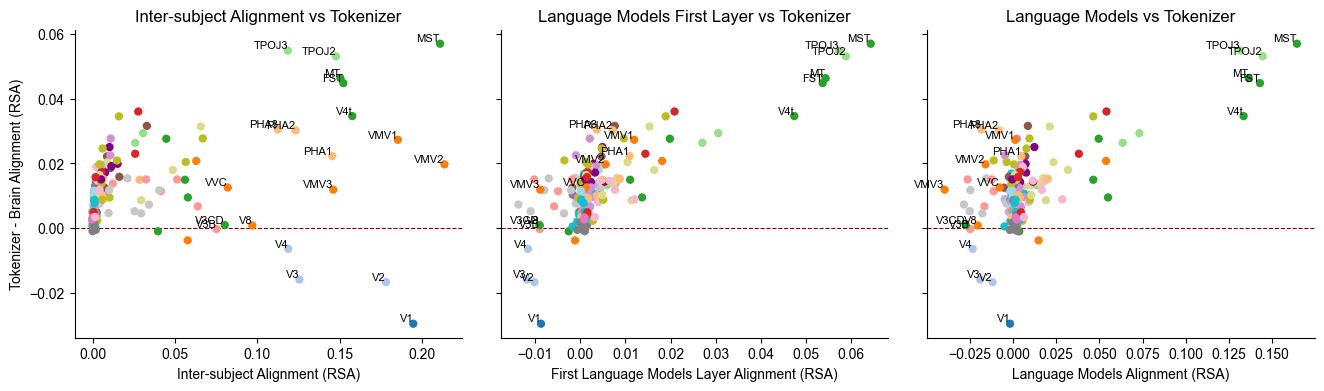

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={"wspace": 0.1})

# Colour scatters by area
palette = df[["area", "area_color"]].drop_duplicates().set_index("area").area_color.to_dict()
scatter_kwargs = dict(hue="area", legend=False, palette=palette, lw=0)
    
# First plot: Intersubject vs Mean tokenizer RSA
sns.scatterplot(data=df, x="intersubject_rsa", y="mean_tokenizers", ax=axes[0], **scatter_kwargs)
axes[0].set_title("Inter-subject Alignment vs Tokenizer")
axes[0].set_ylabel("Tokenizer - Brain Alignment (RSA)")
axes[0].set_xlabel("Inter-subject Alignment (RSA)")

# Second plot: Language RSA first layer vs Mean tokenizer RSA
sns.scatterplot(data=df, x="language_rsa_first_layer", y="mean_tokenizers", ax=axes[1], **scatter_kwargs)
axes[1].set_title("Language Models First Layer vs Tokenizer")
axes[1].set_xlabel("First Language Models Layer Alignment (RSA)")

# Third plot Language RSA max vs Mean tokenizer RSA
sns.scatterplot(data=df, x="language_rsa", y="mean_tokenizers", ax=axes[2], **scatter_kwargs)

axes[2].set_title("Language Models vs Tokenizer")
axes[2].set_xlabel("Language Models Alignment (RSA)")

# Adjust axes
for ax in axes:
    # Add horizontal line at y=0
    ax.axhline(0, color="maroon", linestyle="--", lw=0.8, zorder=-100)
    sns.despine(ax=ax)
    
# Save in pdf without text labels
filename = output_folder / "01_tokenizer_scatter_comparisons.pdf"
fig.savefig(filename, bbox_inches="tight", transparent=True)

# Add names to top areas
top_20 = df.nlargest(20, "intersubject_rsa")
text_kwargs=dict(fontsize=8, ha='right', va='bottom')
for i, row in top_20.iterrows():
    # Add text label to each scatter plot
    x_columns = ["intersubject_rsa", "language_rsa_first_layer", "language_rsa"]
    for x_column, ax in zip(x_columns, axes):
        ax.text(row[x_column], row["mean_tokenizers"], row["name"], **text_kwargs)
    
# Save in svg with text labels for manual edit text labels
fig.savefig(filename.with_suffix(".svg"), bbox_inches="tight", transparent=True)

**Control plot.**  
Check that first‑layer RSA is proportional to each parcel’s max language RSA (expected strong correlation).


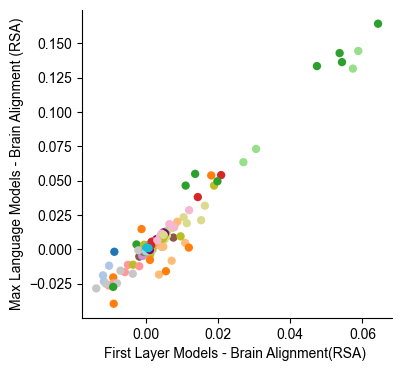

In [10]:
# Scatter of first layer vs max layer
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=df, x="language_rsa_first_layer", y="language_rsa", ax=ax, **scatter_kwargs)
ax.set_xlabel("First Layer Models - Brain Alignment(RSA) ")
ax.set_ylabel("Max Language Models - Brain Alignment (RSA)")
sns.despine(ax=ax)
fig.savefig(output_folder / "01_scatter_first_layer_vs_max_layer.pdf", bbox_inches="tight", transparent=True)

**Report correlations.**  
Pearson (scale) and Spearman (rank) correlations between:  
- First vs Max language RSA,  
- Tokenizer vs First layer,  
- Tokenizer vs Max layer.  
These stats go directly into the text (see sup. section).


In [11]:
corr, p_value = pearsonr(df["language_rsa_first_layer"], df["language_rsa"])
print(f"Correlation between first layer and max layer: {corr:.3f}, p-value: {p_value:.2e}")

corr, p_value = spearmanr(df["language_rsa_first_layer"], df["language_rsa"])
print(f"Spearman correlation between first layer and max layer: {corr:.3f}, p-value: {p_value:.2e}")
print()
# Tokenizer vs first layer
corr, p_value = pearsonr(df["mean_tokenizers"], df["language_rsa_first_layer"])
print(f"Correlation between tokenizer and first layer: {corr:.3f}, p-value: {p_value:.2e}")

corr, p_value = spearmanr(df["mean_tokenizers"], df["language_rsa_first_layer"])
print(f"Spearman correlation between tokenizer and first layer: {corr:.3f}, p-value: {p_value:.2e}")
print()
# Tokenizer vs Max layer
corr, p_value = pearsonr(df["mean_tokenizers"], df["language_rsa"])
print(f"Correlation between tokenizer and max layer: {corr:.3f}, p-value: {p_value:.2e}")
corr, p_value = spearmanr(df["mean_tokenizers"], df["language_rsa"])
print(f"Spearman correlation between tokenizer and max layer: {corr:.3f}, p-value: {p_value:.2e}")

Correlation between first layer and max layer: 0.974, p-value: 2.24e-116
Spearman correlation between first layer and max layer: 0.859, p-value: 1.12e-53

Correlation between tokenizer and first layer: 0.776, p-value: 2.14e-37
Spearman correlation between tokenizer and first layer: 0.600, p-value: 5.79e-19

Correlation between tokenizer and max layer: 0.683, p-value: 4.79e-26
Spearman correlation between tokenizer and max layer: 0.393, p-value: 4.64e-08


**Correlation matrix across all measures.**  
Clustered heatmap (Pearson default; Spearman optional) to visualise measure groups:  
1. Inter‑subject RSA cluster,  
2. Tokenizer family (LLM + word/stem),  
3. Language RSA (first & max) + cleaned word/stem tokenizers.  
Confirms tokenizer similarity and their relationship to shallow language layers.


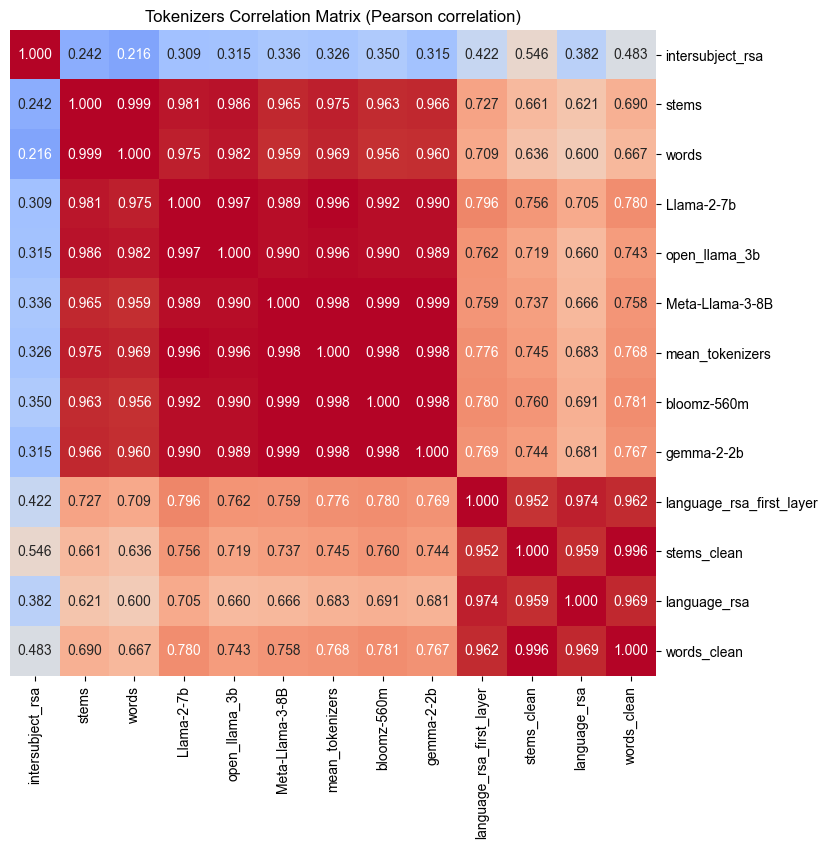

In [12]:
method = "pearson"  # or "spearman"
df_corrs = df.drop(columns=["roi", "name", "area", "area_color", "mne_name"]).corr(method=method)
df_corrs

g = sns.clustermap(df_corrs, annot=True, fmt=".3f", 
                   xticklabels=df_corrs.columns, 
                   yticklabels=df_corrs.index,
                   metric="correlation",
                   cmap="coolwarm",
                   vmin=0, vmax=1,
)
# Hide cbar and dendograms
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.set_title(f"Tokenizers Correlation Matrix ({method.title()} correlation)", fontsize="large")
fig.savefig(output_folder / f"02_tokenizers_correlation_matrix_{method}.pdf", bbox_inches="tight", transparent=True)
        

**Cortical maps (Fig. D/E).**  
Project tokenizer RSA (and first‑layer language RSA) onto fsaverage (LH+RH joined).  
We use symmetric ±0.10 range (RdBu_r). Save lateral/ventral/medial/caudal views for each metric.


In [13]:
tokenizer_brain = [
    'language_rsa_first_layer', 'mean_tokenizers', 'Llama-2-7b',
       'Meta-Llama-3-8B', 'bloomz-560m', 'gemma-2-2b', 'open_llama_3b',
       'stems', 'stems_clean', 'words', 'words_clean'
]
vmax = 0.1
views = ["lateral", "ventral", "medial", "caudal"]

brain_folder = output_folder / "03_tokenizers_brain"
brain_folder.mkdir(exist_ok=True, parents=True)

for column in tokenizer_brain:
    # Plot brain faverage maps for each tokenizer
    brain = plot_faverage_parcelation(
        df,
        value_column=column,
        normalize=(-vmax, vmax),
        cmap="RdBu_r",
        hemisphere="lh",
        default_color="lightgrey",
        default_value=None,
    )

    for view in views:
        brain.show_view(view)
        filename = brain_folder / f"tokenizer_{column}_{view}_{vmax:.1f}.png"
        brain.save_image(filename, mode="rgba")
    brain.close()

Inspect the tokenizers

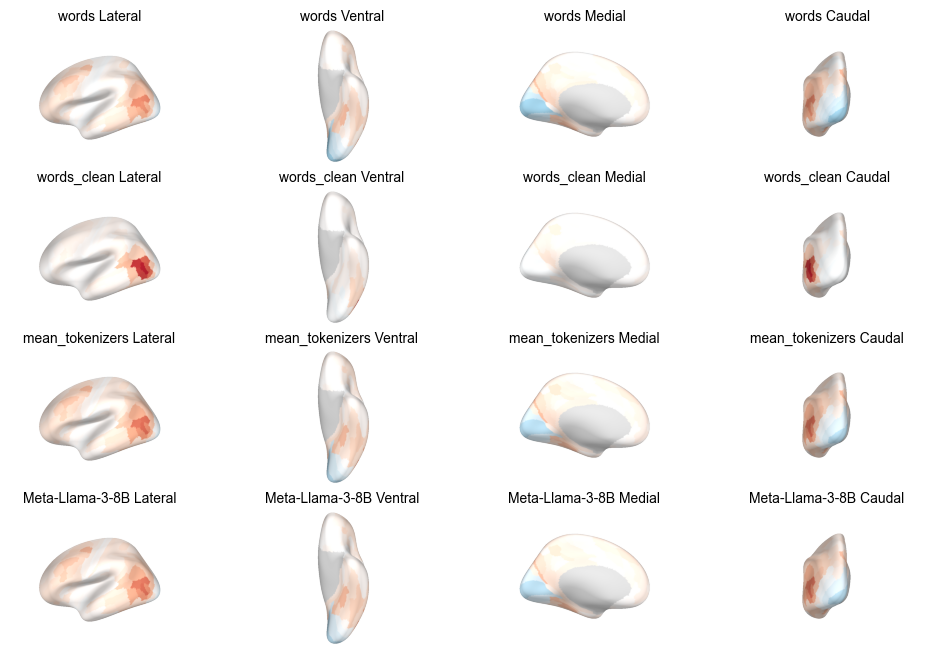

In [ ]:
tokenizers_to_plot = [
     'words', 'words_clean', 'mean_tokenizers',  'Meta-Llama-3-8B',
      #'Llama-2-7b', 'bloomz-560m', 'gemma-2-2b', 'open_llama_3b',
      # #'stems', 'stems_clean', 'language_rsa_first_layer',
]

fig, axes = plt.subplots(len(tokenizers_to_plot), len(views), figsize=(len(views) * 3, len(tokenizers_to_plot) * 2))
for i, tokenizer in enumerate(tokenizers_to_plot):
    for j, view in enumerate(views):
        img_file = brain_folder / f"tokenizer_{tokenizer}_{view}_{vmax:.1f}.png"
        img = plt.imread(img_file)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{tokenizer} {view.capitalize()}", fontsize=10)

**Standalone colourbar.**  
Export a consistent RSA colourbar (−0.05 → 0.10) to reuse in figure assembly.

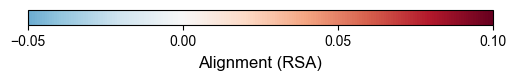

In [15]:
title = "Alignment (RSA)"
filename = output_folder / f"04_tokenizer_colorbar.pdf"
plot_cbar_set(title=title, filename=filename, vmin=-0.05, vmax=vmax, locator=0.05)

Legend of areas color coding**Area legend.**  
Create a swatch legend for HCP macro‑areas used in the scatter plots.

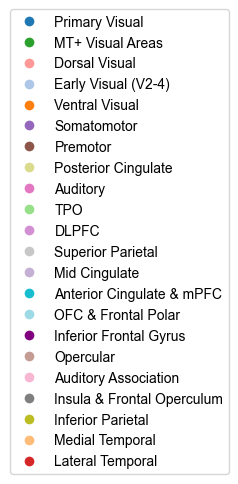

In [16]:


fig, ax = plt.subplots(figsize=(2, 1))
ax.axis("off")
# Use labels and handles
handles = []
labels = []
for area, color in palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=area, markerfacecolor=color, markersize=8, markeredgecolor="white"))
    labels.append(area)

ax.legend(handles=handles, labels=labels, loc='center', ncol=1)


fig.savefig(output_folder / "04_legend_areas.pdf", bbox_inches="tight", transparent=True)

**Take‑home message.**

- Tokenizer‑based RSA strongly resembles full language‑model RSA and peaks in LOTC, with weak/negative EVC alignment.  
- Token counts alone explain a large fraction of first‑layer (r≈.78) and even max‑layer (r≈.68) parcel variability.  
- All LLM tokenizers are virtually indistinguishable at the parcel level; averaging is justified.  
- Word/stem tokenizers reproduce the effect, supporting a **bag‑of‑words** interpretation over deep compositional structure.